# 🌤️ **Multi-class Weather Image Classification**
This project demonstrates image classification on a multi-class weather dataset using deep learning techniques.

## 📂 **Dataset Overview** 

We are using the Multi-class Weather Dataset (MWD), which contains 1,125 labeled images across various weather conditions. The dataset can be downloaded from the link below

🔗 Download the Dataset: https://data.mendeley.com/datasets/4drtyfjtfy/1

## 📁 **Folder Structure**
After downloading and extracting the dataset, follow the directory structure as below for the project to move further

```
project_folder/
│
├── dataset2/
│   ├── cloudy1.jpg
│   ├── shine170.jpg
│   └── ...
├── Notebook.ipynb
└── my_training.csv
├── my_test.csv
└── my_validation.csv
```

## 📄 **Data exploration, Preparation and Partition**

The dataset has been partitioned using the following code, and the following files are included in this repository:

- `my_training.csv`
- `my_validation.csv`
- `my_test.csv`

Each CSV contains two columns:

- `File Path: e.g., dataset2/cloudy1.jpg`

- `Image Label: e.g., cloudy`




### **Preprocessing and Preparation**

Before training the model, we need to:

- Process the images to ensure they are in a consistent format.

- Parse the provided CSV files to load the file paths and corresponding labels.

The "image_process" function:

- Reads the image file from the provided path.

- Decodes the JPEG image into TensorFlow tensors.

- Resizes each image to 230 x 230 pixels.

- Normalizes pixel values to the range [0, 1].

The "decode_csv" function:

- Reads each row of the CSV file.

- Extracts the image path and label.

- Processes the image using image_process.

- Converts the label string to an integer index using tf.argmax and TensorFlow comparison functions.

Here:

- CLASS_NAMES = ["shine", "cloudy", "sunrise", "rain"] is the list of class labels.

- Each label is one-hot encoded and then converted to its corresponding index.

The provided CSV files are read and converted into TensorFlow datasets using by following the below mentioned steps

- Reads from the corresponding CSV.

- Maps the parsing function to each row.

- Batches the data with a batch size of 15.

In [ ]:
pip install tensorflow pandas numpy matplotlib

In [ ]:
pip install torch

In [ ]:
import os
import random
import csv
import re
import pandas as pd
import tensorflow as tf
import glob
from tensorflow.keras import layers, models 
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Getting the current directory 
current_dir = os.getcwd()

# Complete the path of the dataset directory
dataset_dir = os.path.join(current_dir, "dataset2")

# Creating a list of containing the complete absolute paths to all the images
image_files = []
for file in os.listdir(dataset_dir):
    if file.endswith(".jpg"):
        image_files.append(os.path.join(dataset_dir, file))

# Shuffle the image files randomly
random.shuffle(image_files)

# Define the size of each partition (training, validation, test)
total_files = len(image_files)
train_size = int(0.6 * total_files)
val_size = int(0.2 * total_files)
test_size = total_files - train_size - val_size

# Partition the data
train_data = image_files[:train_size]
val_data = image_files[train_size:train_size+val_size]
test_data = image_files[train_size+val_size:]

# Define CSV file names
train_csv = "my_training.csv"
val_csv = "my_validation.csv"
test_csv = "my_test.csv"

# Write data to CSV files
def write_to_csv(file_name, data):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        #jup    writer.writerow(['File path', 'Image label'])
        for file_path in data:
            label = os.path.basename(file_path).split('.')[0]  # Extract label from file name
            label = re.sub(r'\d+', '', label)
            writer.writerow([file_path, label])

write_to_csv(train_csv, train_data)
write_to_csv(val_csv, val_data)
write_to_csv(test_csv, test_data)
# First we will define the functions for processing the image and for parsing the CSV files
# Function to process the image 


CLASS_NAMES = ["shine","cloudy","sunrise","rain"]

def image_process(image_path):
    
    image = tf.io.read_file(image_path) # Reading the image path
    image = tf.image.decode_jpeg(image, channels=3) # Decoding the image into tensors
    image = tf.image.resize(image, [230, 230]) # Resizing the image 
    image = tf.cast(image, tf.float32) / 255.0 # Normalising the pixel values
    return image

def decode_csv(csv_row):
    record_defaults = ["path", "label"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = image_process(filename)
    # Encoding the labels as the index of the Class names array as casting the type to float
    label = tf.argmax(tf.cast(tf.math.equal(CLASS_NAMES, label_string), tf.float32))
    return img, label

test_path = "my_test.csv"
training_path = "my_training.csv"
validation_path = "my_validation.csv"

# Getting the datasets for processing of the models
test_dataset =  tf.data.TextLineDataset(test_path).map(decode_csv).batch(8)
train_dataset =  tf.data.TextLineDataset(training_path).map(decode_csv).batch(8)
val_dataset =  tf.data.TextLineDataset(validation_path).map(decode_csv).batch(8)

### **Visualizing Training Data**

Now before proceeding to the training part, we visualize the current data distribution that we have with respect to each class. As shown by the bar chart, the distribution with respect to each graph is as following

- **Sunrise**: Approximately 225 images
- **Cloudy**: Approximately 175 images
- **Shine**: Approximately 140 images
- **Rain**: Approximately 125 images

The dataset overall looks quite balanced with adequate images for each of the categories under observation

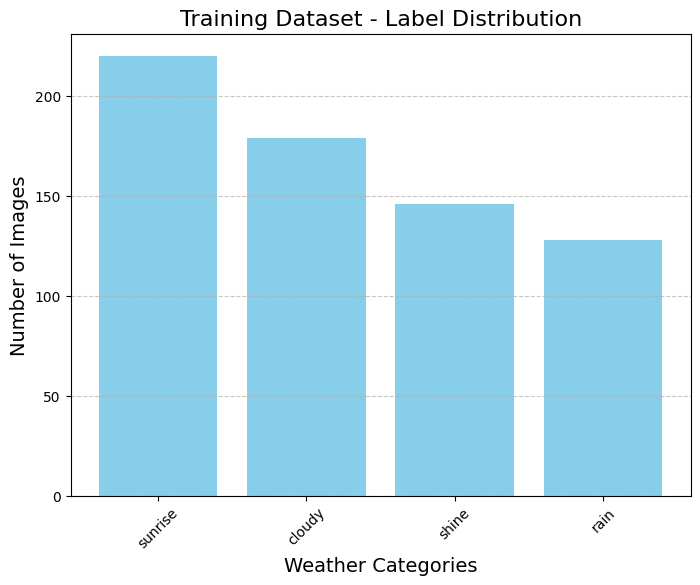

In [46]:
import matplotlib.pyplot as plt
# Load the CSV file into a pandas DataFrame
train_df = pd.read_csv('my_training.csv', header=None, names=['filepath', 'label'])
val_df  = pd.read_csv('my_validation.csv', header=None, names=['filepath', 'label'])

batch_size = 8

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size


# Count the number of images per label
label_counts = train_df['label'].value_counts()

# Plot the label distribution
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.title('Training Dataset - Label Distribution', fontsize=16)
plt.xlabel('Weather Categories', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 🚀 **Model Setup and Training: MobileNet Transfer Learning**

In this section, we leverage the MobileNet architecture pre-trained on the ImageNet dataset to perform weather image classification using transfer learning. We freeze the pre-trained layers and train only the final classification layer to adapt the model to our custom dataset.

### 📦 **Model Architecture**

- Base Model: MobileNet (weights="imagenet")

- Input Shape: (230, 230, 3)

- Pooling: Global Average Pooling

- Trainable Layers: Frozen (no fine-tuning in this step)

- Final Layer: Fully connected Dense layer with softmax activation for 4 weather classes.

### ⚙️ **Model Compilation**

The model is compiled using the Adam optimizer with the custom learning rate schedule and the sparse_categorical_crossentropy loss function, suitable for multi-class classification with integer labels.

### 🏋️ **Training the Model**
The model is trained for 5 epochs using the prepared train_dataset.

In [47]:
# Using the Mobilenet pre-trained model for classification
mobilenet_model = tf.keras.applications.MobileNet(weights="imagenet",
                                                  input_shape=(230,230,3),
                                                  include_top=False,
                                                  pooling="avg")

# Not training the model. Freezing the layers and using transfer learning only for now
for layer in mobilenet_model.layers:
    layer.trainable = False

# Inatialising the model 
model_imagenet = tf.keras.Sequential()

# Adding the first layers as of the pre-trained model
model_imagenet.add(mobilenet_model)

# Adjusting the final layers. The final output layer has size of 4 only because of the output classes
model_imagenet.add(Dense(units = 4, activation='softmax'))

# Defining the learning rate schedule. Using the exponential decay learning rate scheduler
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust the decay steps as needed
    decay_rate=0.96,   # Adjust the decay rate as needed
    staircase=True)

# Compiling the model with the learning schedule rate defined above 
model_imagenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with your dataset
history_imagenet = model_imagenet.fit(
    train_dataset,
    epochs=5
)


/tmp/ipykernel_423/3633985758.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = tf.keras.applications.MobileNet(weights="imagenet",


Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.5434 - loss: 1.1424
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.9341 - loss: 0.3064
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - accuracy: 0.9624 - loss: 0.1918
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 260ms/step - accuracy: 0.9698 - loss: 0.1430
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 268ms/step - accuracy: 0.9734 - loss: 0.1140


### ✅ **Model Evaluation on Test Dataset**
After training, we evaluate the performance of the pre-trained MobileNet classifier on the test dataset to assess its generalization capability

In [48]:
pt_test_loss, pt_test_accuracy = model_imagenet.evaluate(test_dataset)
# Print the test accuracy
print("Test Accuracy for pre trained classifier is:", pt_test_accuracy)

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.9543 - loss: 0.1616
Test Accuracy for pre trained classifier is: 0.9511111378669739


✅ **Key Results**
- Test Accuracy: 95.11%

- Test Loss: 0.1616

📌 **Interpretation**

The model achieved a high accuracy of over 95%, indicating that the MobileNet transfer learning approach was highly effective in classifying weather categories in this dataset.

## 📊 **Per-Class Performance Analysis**

To better understand the model’s performance across different weather categories, we computed the accuracy for each class individually and visualized the results using a bar chart.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

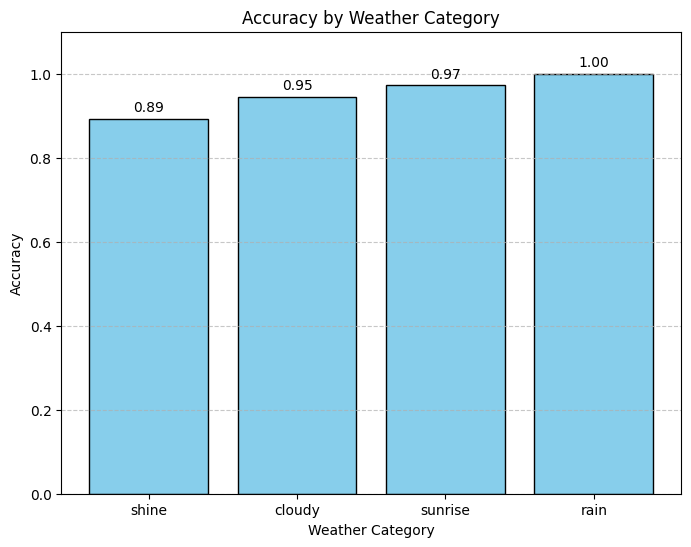

In [49]:
# Initialize dictionaries to store counts and accuracies for each class
class_counts = {class_name: 0 for class_name in CLASS_NAMES}
class_accuracies = {class_name: 0 for class_name in CLASS_NAMES}
accuracies = []
# Iterate over the test dataset and calculate accuracies for each class
for images, labels in test_dataset:
    predictions = model_imagenet.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()
    for true_label, predicted_label in zip(labels.numpy(), predicted_classes):
        class_name = CLASS_NAMES[true_label]
        class_counts[class_name] += 1
        if true_label == predicted_label:
            class_accuracies[class_name] += 1

# Print accuracies for each class
print("\nAccuracy by Weather Category:")
for class_name in CLASS_NAMES:
    accuracy = class_accuracies[class_name] / class_counts[class_name] if class_counts[class_name] > 0 else 0
    accuracies.append(accuracy)
    print(f"{class_name}: {accuracy}")

# Identify the most difficult weather category to detect
most_difficult_weather = max(class_accuracies, key=lambda x: 1 - class_accuracies[x] / class_counts[x])
print("\nMost Difficult Weather Category to Detect:", most_difficult_weather)


# Visualization part
plt.figure(figsize=(8, 6))
bars = plt.bar(CLASS_NAMES, accuracies, color='skyblue', edgecolor='black')

# Add accuracy labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.title('Accuracy by Weather Category')
plt.xlabel('Weather Category')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

✅ **Accuracy by Weather Category**:

The model performs very well across all categories, with the lowest accuracy in the shine category, indicating it is the most challenging for the model to detect.
    
📌 **Insights**:

- Shine is the hardest class for the model, possibly due to similarities with other categories like sunrise or cloudy.

- Rain is perfectly classified in this dataset, indicating strong feature distinguishability.

- Visualizing class-wise performance is critical to identify specific weaknesses in the classifier that may not be evident from overall accuracy alone.